In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
import geopandas as gpd
import contextily as ctx
import rioxarray
import urbanpy as up
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from geocube.api.core import make_geocube

In [2]:
tqdm.pandas()

In [3]:
# Read the grid data
gdf_celdas = gpd.read_parquet("outputs/celdas.parquet")

In [4]:
# Set the base path for the data
BASE_PATH = "/Users/claudio/Documents/amazonia-bid/inputs/WorldPop"
countries_labels = [
    "per",
    "col",
    "bol",
    "ecu",
]  # "bra", TODO: Download brazil data (4GB per file * 6 files)
age_groups = [5, 10, 15]  # 5-9, 10-14, 15-19
genders = ["m", "f"]

In [5]:
# Read the country polygons
countries = gpd.read_parquet(
    "~/Documents/amazonia-bid/outputs/amazon_countries.parquet"
)
countries

,ADM0_EN,ADM0_PCODE,geometry
3,Bolivia (Estado Plurinacional de),BO,"MULTIPOLYGON (((-68.7719 -16.36937, -68.7717 -..."
4,Brazil,BR,"MULTIPOLYGON (((-48.54007 -27.93717, -48.54277..."
7,Colombia,CO,"MULTIPOLYGON (((-78.8898 1.50991, -78.88979 1...."
10,Ecuador,EC,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ..."
12,GUYANA,GY,"MULTIPOLYGON (((-58.58442 6.62612, -58.58609 6..."
19,Peru,PE,"MULTIPOLYGON (((-68.81422 -16.34799, -68.91839..."
22,Suriname,SR,"MULTIPOLYGON (((-55.28819 5.93931, -55.28819 5..."
25,Venezuela (Bolivarian Republic of),VE,"MULTIPOLYGON (((-64.93242 10.15568, -64.92978 ..."


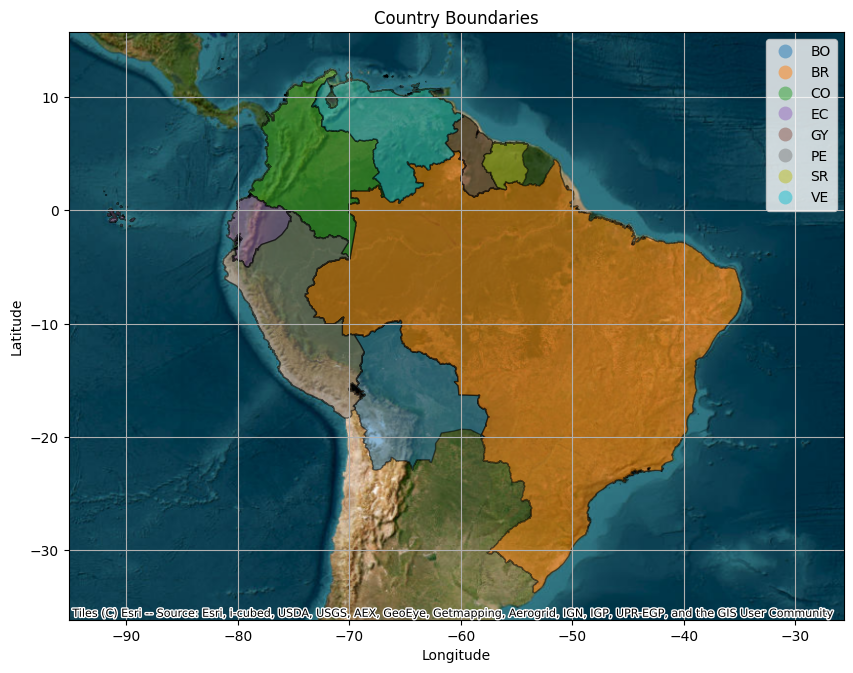

In [6]:
# Visualize the countries
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon with the population data
countries.plot(ax=ax, column="ADM0_PCODE", alpha=0.5, edgecolor="k", legend=True)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=countries.crs)

# Add the title
ax.set_title("Country Boundaries")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [7]:
# Guyana, Suriname, Venezuela are not included in the analysis
countries_ADM0CODE = ["PE", "CO", "EC", "BO"]  # TODO: Fix "BR" data errors
amzn_countries = countries[countries["ADM0_PCODE"].isin(countries_ADM0CODE)]

In [8]:
countries_labels = sorted(countries_labels)
countries_labels

['bol', 'col', 'ecu', 'per']

In [9]:
amzn_countries = amzn_countries.sort_values(by=["ADM0_PCODE"], ascending=True)
amzn_countries

,ADM0_EN,ADM0_PCODE,geometry
3,Bolivia (Estado Plurinacional de),BO,"MULTIPOLYGON (((-68.7719 -16.36937, -68.7717 -..."
7,Colombia,CO,"MULTIPOLYGON (((-78.8898 1.50991, -78.88979 1...."
10,Ecuador,EC,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ..."
19,Peru,PE,"MULTIPOLYGON (((-68.81422 -16.34799, -68.91839..."


In [10]:
amzn_countries["code"] = countries_labels

In [11]:
amzn_countries

,ADM0_EN,ADM0_PCODE,geometry,code
3,Bolivia (Estado Plurinacional de),BO,"MULTIPOLYGON (((-68.7719 -16.36937, -68.7717 -...",bol
7,Colombia,CO,"MULTIPOLYGON (((-78.8898 1.50991, -78.88979 1....",col
10,Ecuador,EC,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ...",ecu
19,Peru,PE,"MULTIPOLYGON (((-68.81422 -16.34799, -68.91839...",per


In [12]:
# Now we will asign a country code to each cell in the grid
gdf_celdas_countries = gdf_celdas.sjoin(
    amzn_countries,
    how="left",
    predicate="intersects",
    lsuffix="celdas",
    rsuffix="countries",
)

In [13]:
# NOTE: We will simply drop the duplicated rows for now
gdf_celdas_countries = gdf_celdas_countries.drop_duplicates(subset=["cell_id"])

In [14]:
# Check the joined data has the same number of rows as the original grid data
try:
    assert (
        gdf_celdas.shape[0] == gdf_celdas_countries.shape[0]
    ), "Number of rows mismatch"
except AssertionError as e:
    print(f"AssertionError: {e}")
    print("Number of rows in gdf_celdas:", gdf_celdas.shape[0])
    print("Number of rows in gdf_celdas_countries:", gdf_celdas_countries.shape[0])

In [16]:
# Save the joined data
gdf_celdas_countries.to_parquet("outputs/celdas_countries_wo_br.parquet")

In [15]:
# Check the unique country codes
gdf_celdas_countries["code"].unique()

array(['per', 'ecu', 'col', nan, 'bol'], dtype=object)

In [16]:
# Check the number of cells per country
gdf_celdas_countries["code"].value_counts()

code
per    9741
bol    4558
ecu    3233
col     743
Name: count, dtype: int64

In [17]:
# Check the percentage of cells per country
gdf_celdas_countries["code"].value_counts(normalize=True) * 100

code
per    53.302326
bol    24.941176
ecu    17.690834
col     4.065663
Name: proportion, dtype: float64

In [18]:
# Check the number of cells without a country code
gdf_celdas_countries["code"].isna().sum()

np.int64(19398)

In [19]:
# Check the percentage of cells without a country code
(gdf_celdas_countries["code"].isna().sum() / gdf_celdas_countries.shape[0]) * 100

np.float64(51.490457356727624)

In [20]:
# Convert the cell_id to integer so it can be rasterized for population aggregation
gdf_celdas_countries["cell_id"] = gdf_celdas_countries["cell_id"].astype("int32")
# check the type
gdf_celdas_countries["cell_id"].dtype

dtype('int32')

In [27]:
# Accumulate the population data for each country
countries_geodata = {}

for index, row in tqdm(
    amzn_countries.iterrows(), total=amzn_countries.shape[0], desc="Countries"
):

    # Filter the country cells
    country = row.code

    # Skip bol for now
    if country in ["per"]:
        continue

    celdas_country = gdf_celdas_countries.loc[
        gdf_celdas_countries["code"] == country, :
    ]
    # print(f"{country=}")
    # print(f"{celdas_country=}")

    # Check the data type of cell_id
    assert (
        celdas_country["cell_id"].dtype == "int32"
    ), f"cell_id is not int32 for {country}"

    # Accumulate the population data for each age group+gender pair
    population_data = []
    for age_group in tqdm(
        age_groups, total=len(age_groups), desc=f"Age Groups for {row.code}"
    ):  # 5-9, 10-14, 15-19
        for gender in tqdm(
            genders, total=len(genders), desc=f"Genders for {row.code} - {age_group}"
        ):  # m, f
            pop_col = f"pop_2020_{gender}_{age_group}"

            file_name = (
                BASE_PATH + f"/{country}/{country}_{gender}_{age_group}_2020.tif"
            )

            # Read the tiff file with the population data
            xds = rioxarray.open_rasterio(
                file_name, masked=True, chunks={"x": 1024, "y": 1024}
            )

            # Clip the raster with the country cells
            xds_clipped = xds.rio.clip(
                celdas_country.geometry.values, celdas_country.crs, from_disk=True
            )
            # print(f"{xds_clipped=}")

            # Rasterize the cell_id to be able to calculate the total population in each cell
            xds_mask = make_geocube(
                celdas_country,
                measurements=["cell_id"],
                like=xds_clipped,
                fill=0,
            )
            # print(f"{xds_mask=}")

            # Add a new dimension to the mask for the population using the clipped raster
            xds_clipped_squeezed = xds_clipped.squeeze()
            xds_mask[pop_col] = (
                xds_clipped_squeezed.dims,
                xds_clipped_squeezed.values,
                xds_clipped_squeezed.attrs,
                xds_clipped_squeezed.encoding,
            )

            # Now we can calculate the total population in each cell and add it back to the geodataframe
            agg_pop = (
                xds_mask.drop_vars("spatial_ref")
                .groupby(xds_mask.cell_id)
                .sum()
                .to_dataframe()
            )

            population_data.append(agg_pop)

        countries_geodata[country] = pd.concat(population_data)

Countries:   0%|          | 0/4 [00:00<?, ?it/s]

Age Groups for bol:   0%|          | 0/3 [00:00<?, ?it/s]

Genders for bol - 5:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Genders for bol - 10:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Genders for bol - 15:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Age Groups for col:   0%|          | 0/3 [00:00<?, ?it/s]

Genders for col - 5:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Genders for col - 10:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Genders for col - 15:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Age Groups for ecu:   0%|          | 0/3 [00:00<?, ?it/s]

Genders for ecu - 5:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Genders for ecu - 10:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Genders for ecu - 15:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [28]:
import os

In [ ]:
for key, value in countries_geodata.items():
    if key == "per":
        continue

    output_fn = f"outputs/{key}_pop_2020.parquet"
    if os.path.exists(output_fn):
        print(f"File {output_fn} already exists. Skipping.")

    countries_geodata[key].reset_index().to_parquet(output_fn, index=False)

In [ ]:
countries_geodata["per"].reset_index().to_parquet(
    "peru_worldpop_school_age_celdas.parquet", index=False
)

In [31]:
countries_geodata["bol"]

,pop_2020_m_5,pop_2020_f_5,pop_2020_m_10,pop_2020_f_10,pop_2020_m_15,pop_2020_f_15
cell_id,,,,,,
0,0.000000,NaN,NaN,NaN,NaN,NaN
13887,0.000000,NaN,NaN,NaN,NaN,NaN
13956,0.036449,NaN,NaN,NaN,NaN,NaN
13993,0.720373,NaN,NaN,NaN,NaN,NaN
13998,0.487070,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
22470,NaN,NaN,NaN,NaN,NaN,6.882991
22577,NaN,NaN,NaN,NaN,NaN,3.475889
22582,NaN,NaN,NaN,NaN,NaN,4.156762


In [32]:
countries_geodata["col"]

,pop_2020_m_5,pop_2020_f_5,pop_2020_m_10,pop_2020_f_10,pop_2020_m_15,pop_2020_f_15
cell_id,,,,,,
0,0.000000,NaN,NaN,NaN,NaN,NaN
4683,22.471271,NaN,NaN,NaN,NaN,NaN
4684,18.745643,NaN,NaN,NaN,NaN,NaN
5024,4.672749,NaN,NaN,NaN,NaN,NaN
5042,5.483823,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
14685,NaN,NaN,NaN,NaN,NaN,0.218060
14693,NaN,NaN,NaN,NaN,NaN,0.082424
14707,NaN,NaN,NaN,NaN,NaN,0.185462


In [37]:
# Check the number of cells per country
gdf_celdas_countries["code"].value_counts()

code
per    9741
bol    4558
ecu    3233
col     743
Name: count, dtype: int64

In [33]:
countries_geodata.keys()

dict_keys(['bol', 'col', 'ecu'])

In [42]:
for key, value in countries_geodata.items():
    print(f"{key}\t {value.shape[0]}")

bol	 27354
col	 4464
ecu	 19404


In [45]:
cells_pop_bol = countries_geodata["bol"]

In [46]:
cells_pop_bol

,pop_2020_m_5,pop_2020_f_5,pop_2020_m_10,pop_2020_f_10,pop_2020_m_15,pop_2020_f_15
cell_id,,,,,,
0,0.000000,NaN,NaN,NaN,NaN,NaN
13887,0.000000,NaN,NaN,NaN,NaN,NaN
13956,0.036449,NaN,NaN,NaN,NaN,NaN
13993,0.720373,NaN,NaN,NaN,NaN,NaN
13998,0.487070,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
22470,NaN,NaN,NaN,NaN,NaN,6.882991
22577,NaN,NaN,NaN,NaN,NaN,3.475889
22582,NaN,NaN,NaN,NaN,NaN,4.156762


In [56]:
clean_dfs = []

for col in cells_pop_bol.columns:
    clean_dfs.append(cells_pop_bol[col].dropna())

In [57]:
clean_dfs_bol = pd.concat(clean_dfs, axis=1)

In [ ]:
clean_dfs_bol.shape[0], (gdf_celdas_countries["code"] == "bol").sum()

(4559, np.int64(4558))

In [65]:
celdas_bol = gdf_celdas_countries[gdf_celdas_countries["code"] == "bol"]

In [66]:
celdas_bol_with_pop = celdas_bol.merge(
    clean_dfs_bol,
    how="left",
    left_on="cell_id",
    right_index=True,
)

In [67]:
celdas_bol_with_pop.shape

(4558, 24)

In [69]:
celdas_bol_with_pop.columns

Index(['cell_id', 'smod', 'pop_1975', 'pop_1980', 'pop_1985', 'pop_1990',
       'pop_1995', 'pop_2000', 'pop_2005', 'pop_2010', 'pop_2015', 'pop_2020',
       'polygon_id', 'geometry', 'index_countries', 'ADM0_EN', 'ADM0_PCODE',
       'code', 'pop_2020_m_5', 'pop_2020_f_5', 'pop_2020_m_10',
       'pop_2020_f_10', 'pop_2020_m_15', 'pop_2020_f_15'],
      dtype='object')

In [ ]:
celdas_bol_with_pop_df = celdas_bol_with_pop[
    [
        "cell_id",
        "smod",
        "geometry",
        "code",
        "pop_2020_m_5",
        "pop_2020_f_5",
        "pop_2020_m_10",
        "pop_2020_f_10",
        "pop_2020_m_15",
        "pop_2020_f_15",
    ]
]

In [ ]:
# poblacion hombres
celdas_bol_with_pop_df["pop_m"] = (
    celdas_bol_with_pop_df["pop_2020_m_5"]
    + celdas_bol_with_pop_df["pop_2020_m_10"]
    + celdas_bol_with_pop_df["pop_2020_m_15"]
)

# poblacion mujeres
celdas_bol_with_pop_df["pop_f"] = (
    celdas_bol_with_pop_df["pop_2020_f_5"]
    + celdas_bol_with_pop_df["pop_2020_f_10"]
    + celdas_bol_with_pop_df["pop_2020_f_15"]
)
# poblacion total
celdas_bol_with_pop_df["pop_total"] = (
    celdas_bol_with_pop_df["pop_m"] + celdas_bol_with_pop_df["pop_f"]
)

# poblacion en edad de escuela primaria
celdas_bol_with_pop_df["pop_primary_school_age"] = (
    celdas_bol_with_pop_df["pop_2020_m_5"] + celdas_bol_with_pop_df["pop_2020_f_5"]
)

# poblacion en edad de escuela secundaria
celdas_bol_with_pop_df["pop_secondary_school_age"] = (
    celdas_bol_with_pop_df["pop_2020_m_10"]
    + celdas_bol_with_pop_df["pop_2020_f_10"]
    + celdas_bol_with_pop_df["pop_2020_m_15"]
    + celdas_bol_with_pop_df["pop_2020_f_15"]
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: Setti

In [73]:
celdas_bol_with_pop_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4558 entries, 13886 to 22586
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cell_id                   4558 non-null   int32   
 1   smod                      4558 non-null   object  
 2   geometry                  4558 non-null   geometry
 3   code                      4558 non-null   object  
 4   pop_2020_m_5              4558 non-null   float64 
 5   pop_2020_f_5              4558 non-null   float64 
 6   pop_2020_m_10             4558 non-null   float64 
 7   pop_2020_f_10             4558 non-null   float64 
 8   pop_2020_m_15             4558 non-null   float64 
 9   pop_2020_f_15             4558 non-null   float64 
 10  pop_m                     4558 non-null   float64 
 11  pop_f                     4558 non-null   float64 
 12  pop_total                 4558 non-null   float64 
 13  pop_primary_school_age    4558 non-null 

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_65325/2864440532.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_data, x='smod', y='Population', hue='Age Group', ci=None, estimator=sum, dodge=True)


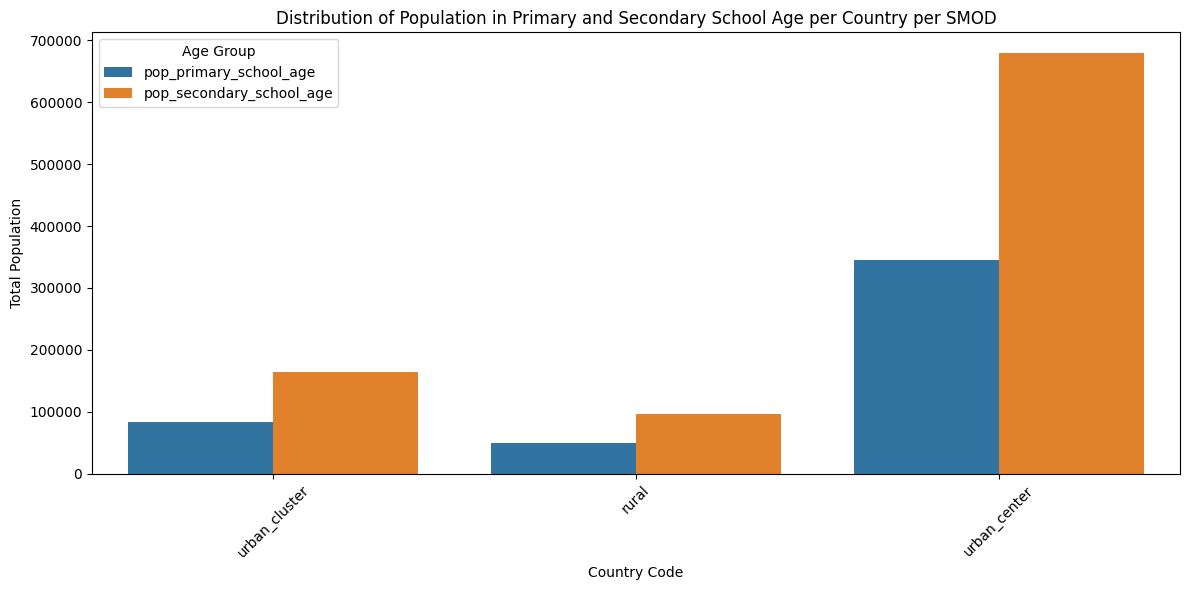

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Prepare the data for plotting
plot_data = celdas_bol_with_pop_df[
    ["code", "smod", "pop_primary_school_age", "pop_secondary_school_age"]
].copy()
plot_data = plot_data.melt(
    id_vars=["code", "smod"],
    value_vars=["pop_primary_school_age", "pop_secondary_school_age"],
    var_name="Age Group",
    value_name="Population",
)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data,
    x="smod",
    y="Population",
    hue="Age Group",
    ci=None,
    estimator=sum,
    dodge=True,
)

# Customize the plot
plt.title(
    "Distribution of Population in Primary and Secondary School Age per Country per SMOD"
)
plt.xlabel("Country Code")
plt.ylabel("Total Population")
plt.legend(title="Age Group")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
peru_pop_data_proc = pd.read_parquet("peru_worldpop_school_age_celdas.parquet")

In [92]:
peru_pop_data_proc.shape

(58452, 7)

In [ ]:
cells_pop_bol["pop_2020_f_5"].isna().sum()

np.int64(22795)

In [ ]:
countries_geodata["per"] = peru_pop_data_proca

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_65325/3674188398.py:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


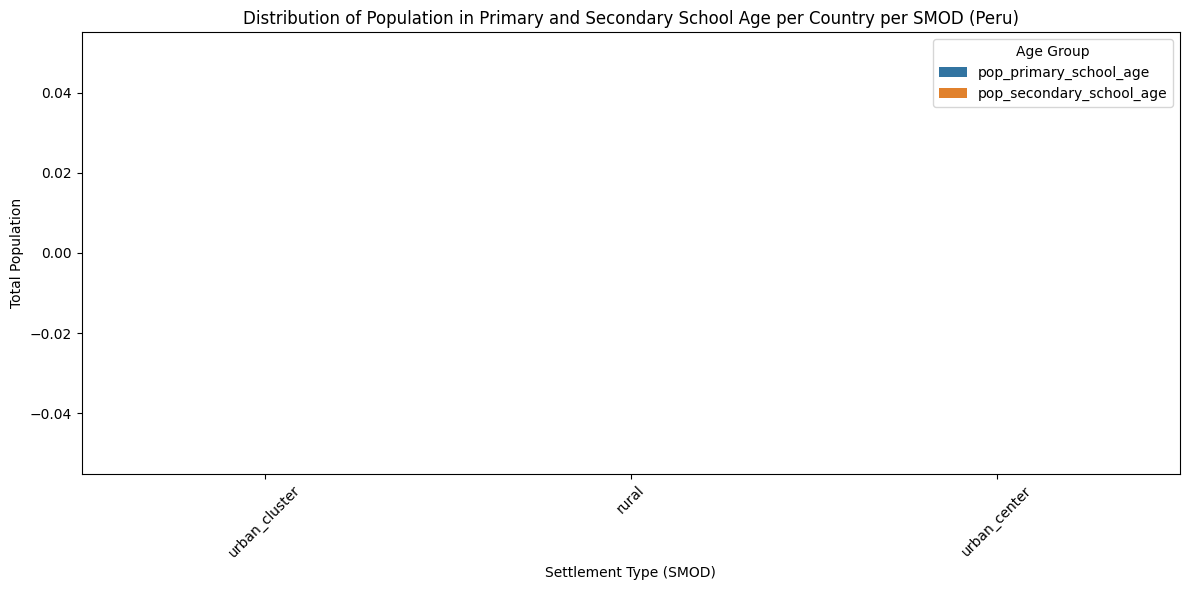

In [ ]:
# Clean the data by dropping NaN values for each column
clean_dfs_per = []
for col in countries_geodata["per"].columns:
    clean_dfs_per.append(countries_geodata["per"][col].dropna())

# Combine the cleaned data into a single DataFrame
clean_dfs_per = pd.concat(clean_dfs_per, axis=1)

# Merge the cleaned data with the grid data for Peru
celdas_per = gdf_celdas_countries[gdf_celdas_countries["code"] == "per"]
celdas_per_with_pop = celdas_per.merge(
    clean_dfs_per,
    how="left",
    left_on="cell_id",
    right_index=True,
)

# Prepare the data for plotting
plot_data_per = celdas_per_with_pop[
    [
        "code",
        "smod",
        "pop_2020_m_5",
        "pop_2020_f_5",
        "pop_2020_m_10",
        "pop_2020_f_10",
        "pop_2020_m_15",
        "pop_2020_f_15",
    ]
].copy()
plot_data_per["pop_primary_school_age"] = (
    plot_data_per["pop_2020_m_5"] + plot_data_per["pop_2020_f_5"]
)
plot_data_per["pop_secondary_school_age"] = (
    plot_data_per["pop_2020_m_10"]
    + plot_data_per["pop_2020_f_10"]
    + plot_data_per["pop_2020_m_15"]
    + plot_data_per["pop_2020_f_15"]
)
plot_data_per = plot_data_per.melt(
    id_vars=["code", "smod"],
    value_vars=["pop_primary_school_age", "pop_secondary_school_age"],
    var_name="Age Group",
    value_name="Population",
)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data_per,
    x="smod",
    y="Population",
    hue="Age Group",
    ci=None,
    estimator=sum,
    dodge=True,
)

# Customize the plot
plt.title(
    "Distribution of Population in Primary and Secondary School Age per Country per SMOD (Peru)"
)
plt.xlabel("Settlement Type (SMOD)")
plt.ylabel("Total Population")
plt.legend(title="Age Group")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
# Extract the population data for Colombia
cells_pop_col = countries_geodata["col"]

In [79]:
# Clean the data by dropping NaN values for each column
clean_dfs_col = []
for col in cells_pop_col.columns:
    clean_dfs_col.append(cells_pop_col[col].dropna())

In [ ]:
# Combine the cleaned data into a single DataFrame
clean_dfs_col = pd.concat(clean_dfs_col, axis=1)

In [ ]:
# Merge the cleaned data with the grid data for Colombia
celdas_col = gdf_celdas_countries[gdf_celdas_countries["code"] == "col"]
celdas_col_with_pop = celdas_col.merge(
    clean_dfs_col,
    how="left",
    left_on="cell_id",
    right_index=True,
)

In [ ]:
# Prepare the data for plotting
plot_data_col = celdas_col_with_pop[
    [
        "code",
        "smod",
        "pop_2020_m_5",
        "pop_2020_f_5",
        "pop_2020_m_10",
        "pop_2020_f_10",
        "pop_2020_m_15",
        "pop_2020_f_15",
    ]
].copy()
plot_data_col["pop_primary_school_age"] = (
    plot_data_col["pop_2020_m_5"] + plot_data_col["pop_2020_f_5"]
)
plot_data_col["pop_secondary_school_age"] = (
    plot_data_col["pop_2020_m_10"]
    + plot_data_col["pop_2020_f_10"]
    + plot_data_col["pop_2020_m_15"]
    + plot_data_col["pop_2020_f_15"]
)
plot_data_col = plot_data_col.melt(
    id_vars=["code", "smod"],
    value_vars=["pop_primary_school_age", "pop_secondary_school_age"],
    var_name="Age Group",
    value_name="Population",
)

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_65325/2161522189.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


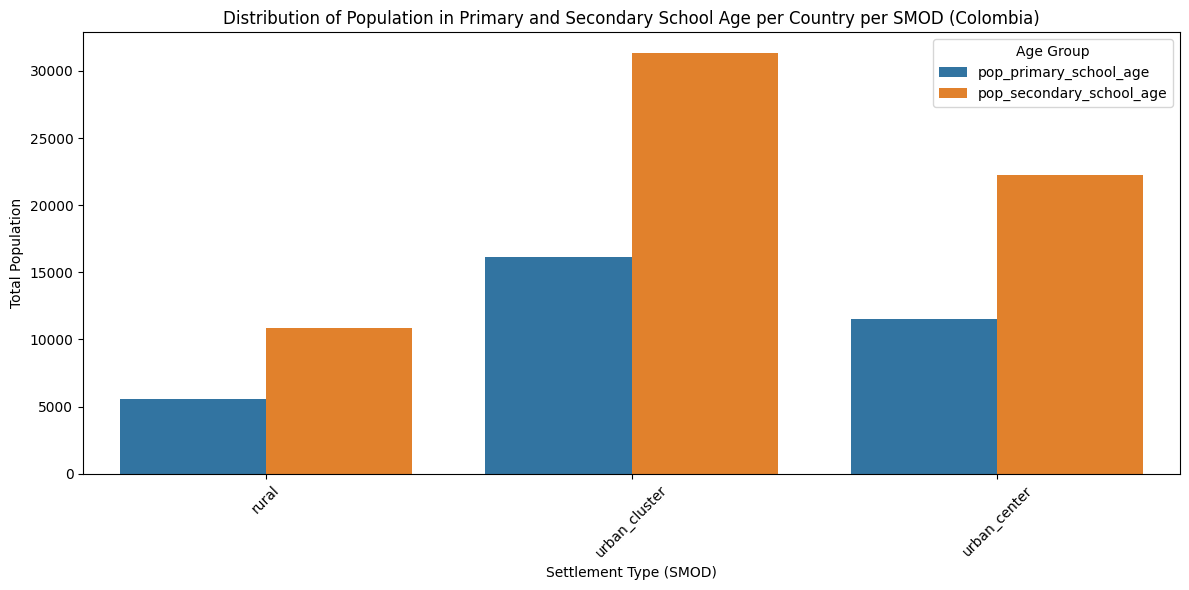

In [ ]:
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data_col,
    x="smod",
    y="Population",
    hue="Age Group",
    ci=None,
    estimator=sum,
    dodge=True,
)

# Customize the plot
plt.title(
    "Distribution of Population in Primary and Secondary School Age per Country per SMOD (Colombia)"
)
plt.xlabel("Settlement Type (SMOD)")
plt.ylabel("Total Population")
plt.legend(title="Age Group")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_65325/2995044402.py:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


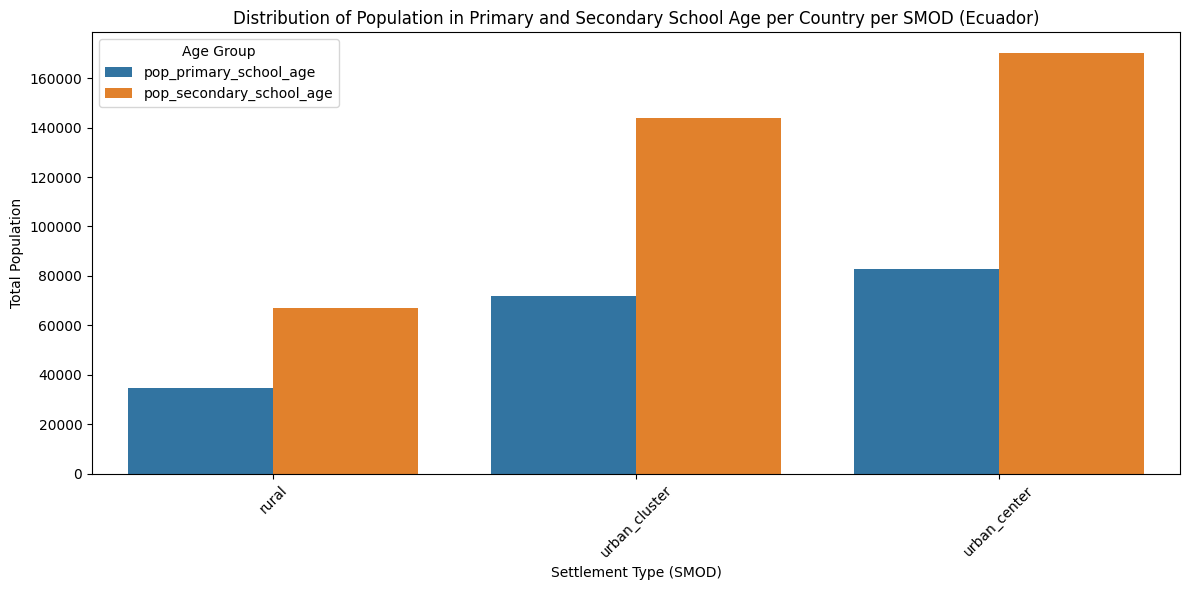

In [ ]:
# Clean the data by dropping NaN values for each column
clean_dfs_ecu = []
for col in countries_geodata["ecu"].columns:
    clean_dfs_ecu.append(countries_geodata["ecu"][col].dropna())

# Combine the cleaned data into a single DataFrame
clean_dfs_ecu = pd.concat(clean_dfs_ecu, axis=1)

# Merge the cleaned data with the grid data for Ecuador
celdas_ecu = gdf_celdas_countries[gdf_celdas_countries["code"] == "ecu"]
celdas_ecu_with_pop = celdas_ecu.merge(
    clean_dfs_ecu,
    how="left",
    left_on="cell_id",
    right_index=True,
)

# Prepare the data for plotting
plot_data_ecu = celdas_ecu_with_pop[
    [
        "code",
        "smod",
        "pop_2020_m_5",
        "pop_2020_f_5",
        "pop_2020_m_10",
        "pop_2020_f_10",
        "pop_2020_m_15",
        "pop_2020_f_15",
    ]
].copy()
plot_data_ecu["pop_primary_school_age"] = (
    plot_data_ecu["pop_2020_m_5"] + plot_data_ecu["pop_2020_f_5"]
)
plot_data_ecu["pop_secondary_school_age"] = (
    plot_data_ecu["pop_2020_m_10"]
    + plot_data_ecu["pop_2020_f_10"]
    + plot_data_ecu["pop_2020_m_15"]
    + plot_data_ecu["pop_2020_f_15"]
)
plot_data_ecu = plot_data_ecu.melt(
    id_vars=["code", "smod"],
    value_vars=["pop_primary_school_age", "pop_secondary_school_age"],
    var_name="Age Group",
    value_name="Population",
)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data_ecu,
    x="smod",
    y="Population",
    hue="Age Group",
    ci=None,
    estimator=sum,
    dodge=True,
)

# Customize the plot
plt.title(
    "Distribution of Population in Primary and Secondary School Age per Country per SMOD (Ecuador)"
)
plt.xlabel("Settlement Type (SMOD)")
plt.ylabel("Total Population")
plt.legend(title="Age Group")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
cells_pop_bol["pop_2020_f_5"].isna().sum()

np.int64(22795)

In [54]:
cells_pop_bol["pop_2020_f_10"].isna().sum()

np.int64(22795)

In [55]:
cells_pop_bol["pop_2020_f_15"].isna().sum()

np.int64(22795)

In [ ]:
countries_geodata["bol"].shape

In [ ]:
xds_clipped

In [ ]:
celdas_country

In [ ]:
fig, ax = plt.subplots()


xds_clipped.squeeze().plot.imshow(
    ax=ax,
    cmap="viridis",
    add_colorbar=True,
    cbar_kwargs={"label": "Population"},
)

celdas_country.plot(
    ax=ax,
    color="red",
    alpha=0.5,
)

plt.show()

In [ ]:
celdas_country.head()

In [ ]:
celdas_country.info()

In [ ]:
celdas_country["cell_id"] = celdas_country["cell_id"].astype(float)

In [ ]:
celdas_country.shape

In [ ]:
celdas_country["cell_id"].unique().shape

In [ ]:
xds_mask = make_geocube(
    vector_data=celdas_country[["cell_id", "geometry"]],
    # measurements=["cell_id"],
    like=xds_clipped,
    fill=0,
)
xds_mask

In [ ]:
# Add a new dimension to the mask for the population using the clipped raster
xds_clipped_squeezed = xds_clipped.squeeze()
xds_mask[pop_col] = (
    xds_clipped_squeezed.dims,
    xds_clipped_squeezed.values,
    xds_clipped_squeezed.attrs,
    xds_clipped_squeezed.encoding,
)
xds_mask

In [ ]:
# Now we can calculate the total population in each cell and add it back to the geodataframe
agg_pop = (
    xds_mask.drop_vars("spatial_ref").groupby(xds_mask.cell_id).sum().to_dataframe()
)

In [ ]:
import dask

In [ ]:
# Now we can calculate the total population in each cell and add it back to the geodataframe
agg_pop_1 = (
    xds_mask.drop_vars("spatial_ref").groupby(xds_mask.cell_id).sum().to_dataframe()
)

In [ ]:
agg_pop.shape, celdas_country.shape

In [ ]:
population_data.append(agg_pop)

countries_geodata[country] = pd.concat(population_data)

In [ ]:
plotly.offline.init_notebook_mode()

In [ ]:
fig = up.plotting.choropleth_map(
    peru_access,
    "pop_2020",
    title="Estimated Population - 2020",
    opacity=0.5,
    width=800,
    height=800,
)

# Make space for the title
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))

fig.show()

In [ ]:
# Get ordered category labels
category_orders = (
    huancabamba_access["duration_to_nearest_schools_label"].unique().sort_values()
)
category_orders.categories

In [ ]:
fig = up.plotting.choropleth_map(
    peru_access,
    color_column="duration_to_nearest_schools_label",
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    category_orders={"duration_to_nearest_schools_label": category_orders},
    opacity=0.5,
    labels={"duration_to_nearest_schools_label": "Minutes"},
    title="Travel Time to Nearest School",
    width=800,
    height=800,
)

# Make space for the title
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))

# Remove the hexagon outlines to make the map clearer
fig.update_traces(marker_line_width=0)

fig.show()